In [38]:
import os
import numpy as np
from matplotlib.pyplot import *
import h5py
import datetime
import pytz
import pickle
import glob
from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
gbosite=site.site('/home/erk26/newburghlabdrone/beamcals/beamcals/sites/GBO_config.npz')

In [39]:
class dict_to_class:
    def __init__(self,dictionary):
        for key in dictionary.keys():
            setattr(self,key,dictionary[key])

class dict_to_class_cut:
    def __init__(self,dictionary):
        for key in dictionary.keys():
            if 'bg' not in key or 'sub' in key:
                setattr(self,key,dictionary[key])

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

def Gauss_2d_LC_func(P,x,y):
    amp,x0,xsig,y0,ysig,c=P
    return amp*np.exp(-0.5*((((x-x0)/xsig)**2.0)+(((y-y0)/ysig)**2.0)))+c

def Gauss_2d_LC_func_gen(P,x,y):
    amp,x0,xsig,y0,ysig,theta,c=P
    A=(0.5*(((np.cos(theta)/xsig)**2.0)+((np.sin(theta)/ysig)**2.0)))
    B=(0.25*((np.sin(2.0*theta)/(ysig**2.0))-(np.sin(2.0*theta)/(xsig**2.0))))
    C=(0.5*(((np.sin(theta)/xsig)**2.0)+((np.cos(theta)/ysig)**2.0)))
    return amp*np.exp(-1.0*((A*((x-x0)**2.0))+(2.0*B*(x-x0)*(y-y0))+(C*((y-y0)**2.0))))+c

def Gauss_2d_LC_opt_gen(P,x,y,V):
    amp,x0,xsig,y0,ysig,theta,c=P
    A=(0.5*(((np.cos(theta)/xsig)**2.0)+((np.sin(theta)/ysig)**2.0)))
    B=(0.25*((np.sin(2.0*theta)/(ysig**2.0))-(np.sin(2.0*theta)/(xsig**2.0))))
    C=(0.5*(((np.sin(theta)/xsig)**2.0)+((np.cos(theta)/ysig)**2.0)))
    return amp*np.exp(-1.0*((A*((x-x0)**2.0))+(2.0*B*(x-x0)*(y-y0))+(C*((y-y0)**2.0))))+c-V


In [40]:
## AUGUST 26 FLIGHT READ IN

keys826 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/*')]
keys826.sort()

dict826 = {}

for key in ['20210826T170324Z', '20210826T182915Z','20210826T195014Z']:
    with open('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    dict826[key] = dict_to_class_cut(loaded_dict)
    print(key)


20210826T170324Z
20210826T182915Z
20210826T195014Z


In [17]:
# ## AUGUST 26 FLIGHT READ IN

# keys826 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/*')]
# keys826.sort()

# dict826 = {}

# for key in keys826:
#     with open('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
#         loaded_dict = pickle.load(f)
#     dict826[key] = dict_to_class_cut(loaded_dict)
#     print(key)


In [13]:
# for find in [200, 400, 600, 900]:
#     fig=figure(figsize=(12,8))
#     for counter, num in enumerate([3,4]):
#         if num in [3,4]: j = 0
#         else: j = 0
#         tempconcat=dict826[keys826[num]]

#         tacut=tempconcat.t_index[tempconcat.V[:,find,j]<0.999*(np.nanmax(tempconcat.V[:,find,j]))]
#         txcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,0])<50.0]
#         tycut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,1])<50.0]
#         tzcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,2])>150.0]
#         ttcut=np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(txcut,tycut),tzcut),tacut),tempconcat.inds_on)
#         inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
#         ## data points for fit:
#         mbx=tempconcat.drone_xyz_LC_interp[ttcut,0]
#         mby=tempconcat.drone_xyz_LC_interp[ttcut,1]
#         mbz=tempconcat.drone_xyz_LC_interp[ttcut,2]
#         mbV=tempconcat.V[ttcut,find,j]
#         mb_input_data=np.array([mbx,mby,mbV])
#         ## shared params:
#         amp0=np.nanmax(mbV)
#         bg0=np.nanmin(mbV)
#         x00=tempconcat.dish_coords[int(j/2),0]
#         y00=tempconcat.dish_coords[int(j/2),1]
#         ## airy params:
#         rad0=25.0
#         ## 2dgauss params:
#         xsig0=6.0
#         ysig0=6.0
#         theta0=0.0
#         pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])
#         Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x
#         if num == 3:
#             Gpopt5=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x


#         ax=fig.add_subplot(2,3,3*(counter)+1)
#         ax.set_title('Flight' + str(num))
#         ax.set_facecolor('k')
#         ax.scatter(tempconcat.drone_xyz_LC_interp[inds_on_cut,0],tempconcat.drone_xyz_LC_interp[inds_on_cut,1],\
#                    c=tempconcat.V[inds_on_cut,find,j], norm=LogNorm(), s = 3)


#         ax=fig.add_subplot(2,3,3*(counter)+2)
#         ax.set_title('X Cut, Flight' + str(num)) 
#         zplot = Gauss_2d_LC_func_gen(Gpopt,np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),Gpopt[3]*np.ones(100))
#         ax.scatter(mbx,mbV/zplot.max(),c='C8',norm=LogNorm(), s = 4, label = 'data')
#         ax.plot(np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),zplot/zplot.max(),'b.--',label='X fit, flight ' +str(num))
#         zplot = Gauss_2d_LC_func_gen(Gpopt5,np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),Gpopt5[3]*np.ones(100))
#         ax.plot(np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),zplot/zplot.max(),'g.--',label='X fit, low power flight ')
#         ax.semilogy


#         ax=fig.add_subplot(2,3,3*(counter)+3)
#         ax.set_title('Y Cut, Flight' + str(num))
#         zplot = Gauss_2d_LC_func_gen(Gpopt,Gpopt[1]*np.ones(100),np.linspace(np.nanmin(mby),np.nanmax(mby),100))
#         ax.scatter(mby,mbV/zplot.max(), c = 'C8',norm=LogNorm(), s = 4, label = 'data')
#         ax.plot(np.linspace(np.nanmin(mby),np.nanmax(mby),100),zplot/zplot.max(),'b.--',label='Y fit, flight ' +str(num))
#         zplot = Gauss_2d_LC_func_gen(Gpopt5,Gpopt5[1]*np.ones(100),np.linspace(np.nanmin(mby),np.nanmax(mby),100))
#         ax.plot(np.linspace(np.nanmin(mby),np.nanmax(mby),100),zplot/zplot.max(),'g.--',label='Y fit, low power flight ')
#         ax.semilogy
        
#     suptitle(str(tempconcat.freq[find])+'MHz', fontsize = 12)
#     tight_layout()
#     show()



In [14]:
# fitparams = {}
# for find in np.arange(100,1000,10):
#     fitparams[find] = {}
#     for num in [1,2,5][::-1]:
#         if num in [1,2,5]: j = 1
#         else: j = 0
#         tempconcat=dict826[keys826[num]]

#         tacut=tempconcat.t_index[tempconcat.V[:,find,j]<0.999*(np.nanmax(tempconcat.V[:,find,j]))]
#         txcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,0])<50.0]
#         tycut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,1])<50.0]
#         tzcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,2])>150.0]
#         ttcut=np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(txcut,tycut),tzcut),tacut),tempconcat.inds_on)
#         inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
#         ## data points for fit:
#         mbx=tempconcat.drone_xyz_LC_interp[ttcut,0]
#         mby=tempconcat.drone_xyz_LC_interp[ttcut,1]
#         mbz=tempconcat.drone_xyz_LC_interp[ttcut,2]
#         mbV=tempconcat.V[ttcut,find,j]
#         mb_input_data=np.array([mbx,mby,mbV])
#         ## shared params:
#         amp0=np.nanmax(mbV)
#         bg0=np.nanmin(mbV)
#         x00=tempconcat.dish_coords[int(j/2),0]
#         y00=tempconcat.dish_coords[int(j/2),1]
#         ## airy params:
#         rad0=25.0
#         ## 2dgauss params:
#         xsig0=6.0
#         ysig0=6.0
#         theta0=0.0
#         pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])
#         Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x
#         fitparams[find][num] = Gpopt

In [43]:
dict826[list(dict826.keys())[5]].n_dishes
x,y = np.meshgrid(np.linspace(-100,100,100), np.linspace(-100,100,100))

num = 5 
fitparams = {}
fits_all_norm = {}
for num in np.arange(0,6,1):
    fits = np.zeros((90, dict826[list(dict826.keys())[num]].n_dishes, 7))
    fitsnorm = np.zeros((90, dict826[list(dict826.keys())[num]].n_dishes, 7))
    for i, find in enumerate(np.arange(100,1000,10)):
        for j, pol in enumerate(np.arange(1,16,2)):
            try:
                tempconcat=dict826[keys826[num]]
                tacut=tempconcat.t_index[tempconcat.V[:,find,pol]<0.999*(np.nanmax(tempconcat.V[:,find,pol]))]
                txcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,0])<50.0]
                tycut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,1])<50.0]
                tzcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,2])>150.0]
                ttcut=np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(txcut,tycut),tzcut),tacut),tempconcat.inds_on)
                inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
                ## data points for fit:
                mbx=tempconcat.drone_xyz_LC_interp[ttcut,0]
                mby=tempconcat.drone_xyz_LC_interp[ttcut,1]
                mbz=tempconcat.drone_xyz_LC_interp[ttcut,2]
                mbV=tempconcat.V[ttcut,find,pol]
                mbV=np.mean(np.abs(tempconcat.V_bgsub[ttcut,find:find+10,pol]), axis = 1)                
                mb_input_data=np.array([mbx,mby,mbV])
                ## shared params:
                amp0=np.nanmax(mbV)
                bg0=np.nanmin(mbV)
                x00=tempconcat.dish_coords[int(pol/2),0]
                y00=tempconcat.dish_coords[int(pol/2),1]
                ## airy params:
                rad0=25.0
                ## 2dgauss params:
                xsig0=6.0
                ysig0=6.0
                theta0=0.0
                pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])
                Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x
                z = Gauss_2d_LC_func_gen(Gpopt,x,y)
                Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=Gpopt,args=[x.ravel(),y.ravel(),z.ravel()]).x            
                for k, param in enumerate(Gpopt):
                    fits[i,j,k] = param
                z = z/z.max()
                Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=Gpopt,args=[x.ravel(),y.ravel(),z.ravel()]).x            
                for k, param in enumerate(Gpopt):
                    fitsnorm[i,j,k] = param
            except: pass
    fitparams[num] = fits
    fits_all_norm[num] = fitsnorm

IndexError: list index out of range

In [ ]:
param_labels = ['amp','x0','xsig','y0','ysig','theta','c']

fig=figure(figsize=(14,12))

for j, dishnum in enumerate([0,1,2,3,4,5,7]):
    for k in range(len(fits_all_norm[num][0,0,:])):
        ax=fig.add_subplot(8,7,j*7+k+1)
        try:
            ax.plot(np.linspace(400,800,1024)[np.arange(100,1000,10)], \
                    100*(fits_all_norm[2][:,dishnum,k]-fits_all_norm[5][:,dishnum,k])/fits_all_norm[5][:,dishnum,k], label = i)
        except: pass
        # ylim(0.75,1)
        if dishnum == 0: ax.set_title(param_labels[k])
        if k == 0: ax.set_ylabel('Dish '+str(dishnum))
#         ax.set_xlabel('frequency')
        ax.set_xlim(450,800)
        ax.set_ylim(-10,10)
        ax.axhspan(-1,1,alpha = 0.1)
    tight_layout()


In [41]:
import math

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [42]:
fitparams.keys()

NameError: name 'fitparams' is not defined

In [ ]:
fitparams[5].shape
fitparams[2][80,0,0]

In [44]:
X,Y = np.meshgrid(np.linspace(-100,100,1000), np.linspace(-100,100,1000))
freq = 900

num = 1
inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict826[keys826[num]].drone_xyz_LC_interp[j,0]) != 'nan']
x = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0]
y = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1]
z = (np.abs(np.mean(dict826[keys826[num]].V_bgsub[indsuse,freq:freq+20,1], axis = 1)))
# Z1 = griddata((x,y), z, (X,Y))/fitparams[2][80,0,0]
Z1 = griddata((x,y), z, (X,Y))

# num = 5
# inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
# indsuse = [j for j in inds_on_cut if str(dict826[keys826[num]].drone_xyz_LC_interp[j,0]) != 'nan']
# x = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0]
# y = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1]
# z = (np.abs(np.mean(dict826[keys826[num]].V_bgsub[indsuse,freq:freq+20,1], axis = 1)))
# # Z5 = griddata((x,y), z, (X,Y))/fitparams[5][80,0,0]
# Z5 = griddata((x,y), z, (X,Y))

# show()

# plot(Z1[:,500])
# plot(Z5[:,500])
# semilogy()

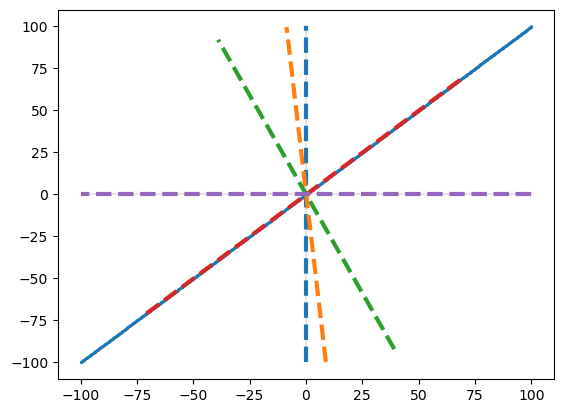

In [45]:
#Rotation example

plot(X[500,:], Y[500,:], color = 'black', alpha = 0.1)
plot(X[:,500], Y[:,500], color = 'black', alpha = 0.1)
# scatter(np.diag(X), np.diag(Y), s = 1)
# scatter(np.diag(X, k=100), np.diag(Y, k=100), s = 1)

scatter(np.diagonal(X, axis1=1, axis2=0), np.diagonal(Y, axis1=1, axis2=0), s = 1)

for angle in [0, 5, 23, -45, 90]:
    ang = angle*np.pi/180
    Xrot, Yrot = rotate((0,0), (X,Y) , ang)
    plot(Xrot[:,500], Yrot[:,500], linestyle = '--', linewidth = 3)


In [46]:
X,Y = np.meshgrid(np.linspace(-100,100,1000), np.linspace(-100,100,1000))
Z12 = griddata((x,y), z, (X,Y))

Xrot, Yrot = rotate((0,0), (X,Y) , 45*np.pi/180)
Z12rot = griddata((x,y), z, (Xrot,Yrot))

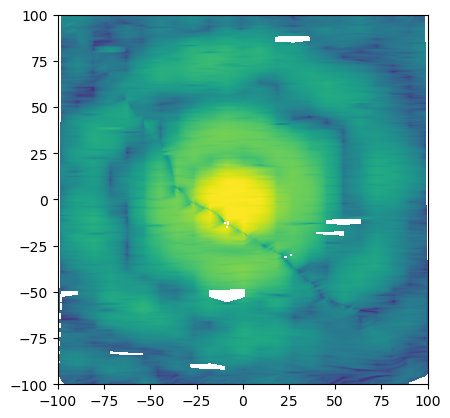

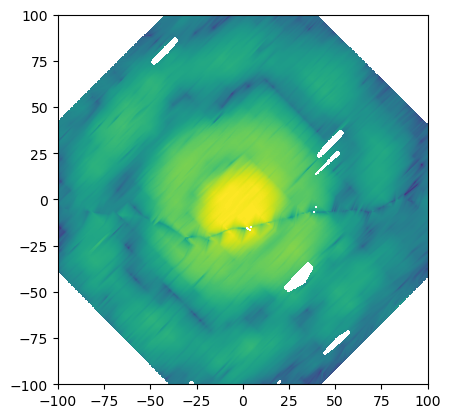

In [47]:
#ok can rotate data
imshow(10*np.log10(Z12), extent=(-100,100,-100,100))
show()

# plot(Xrot[:,500], Yrot[:,500], linestyle = '--', linewidth = 3)

imshow(10*np.log10(Z12rot), extent=(-100,100,-100,100))
show()

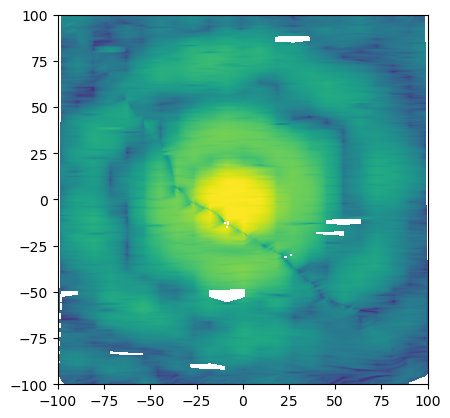

In [48]:
imshow(10*np.log10(Z1), extent=(-100,100,-100,100))


In [49]:
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline

In [50]:
len(x)

11585

In [51]:
indsuse = np.where((x==x)&(y==y)&(z==z))[0]

x = x[indsuse]
y = y[indsuse]
z = 10*np.log10(z[indsuse])
# z = z[indsuse]

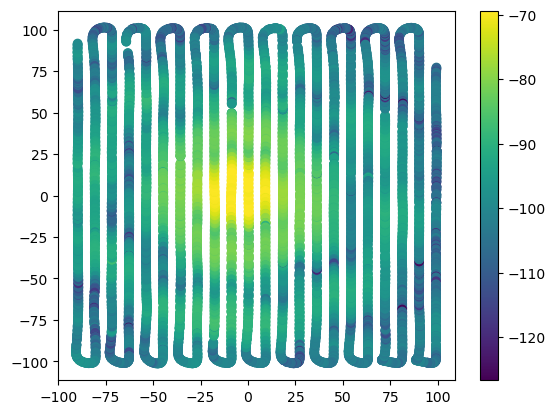

In [52]:
lb = 2000
ub = -2000

scatter(x[lb:ub],y[lb:ub],c = z[lb:ub])
colorbar()

In [53]:
# x = np.linspace(0, 4, 13)
# y = np.array([0, 2, 3, 3.5, 3.75, 3.875, 3.9375, 4])
# X, Y = np.meshgrid(x, y)
# Z = np.sin(np.pi*X/2) * np.exp(Y/2)

# x2 = np.linspace(0, 4, 65)
# y2 = np.linspace(0, 4, 65)
# f = interp2d(x, y, Z, kind='cubic')
# Z2 = f(x2, y2)

# fig, ax = subplots(nrows=1, ncols=2)
# ax[0].pcolormesh(X, Y, Z)

# X2, Y2 = np.meshgrid(x2, y2)
# ax[1].pcolormesh(X2, Y2, Z2)



In [54]:
num = 1
inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict826[keys826[num]].drone_xyz_LC_interp[j,0]) != 'nan']
x = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0]
y = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1]
z = (np.abs(np.mean(dict826[keys826[num]].V_bgsub[indsuse,freq:freq+20,1], axis = 1)))
Z1 = griddata((x,y), z, (X,Y))


In [55]:
indsuse = np.where((x==x)&(y==y)&(z==z))[0]

x = x[indsuse]
y = y[indsuse]
z = 10*np.log10(z[indsuse])

In [56]:
Z_func = interp2d(x,y,z)

/home/erk26/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=87,138 m=11538 fp=42027.480583 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [57]:
X,Y = np.meshgrid(np.linspace(-95,95,1000), np.linspace(-95,95,1000))
Z1 = griddata((x,y), z, (X,Y))

# Z_func = RectBivariateSpline(np.linspace(-100,100,1000), np.linspace(-100,100,1000), Z1)
Z_func = interp2d(np.linspace(-95,95,1000), np.linspace(-95,95,1000), Z1)

In [ ]:
xs = np.linspace(-100,100,100)
plot(xs, [Z_func(xx,0) for xx in xs])
plot(xs, [Z_func(0,xx) for xx in xs])
plot(np.linspace(-95,95,1000), Z1[:,500], linewidth = 3, alpha = 0.4)
plot(np.linspace(-95,95,1000), Z1[500,:], linewidth = 3, alpha = 0.4)

# ylim(-100,200)

In [35]:
# Z_func = interp2d(x,y,z)


In [36]:
Z_func(0,0)

array([-69.44880632])

In [37]:
interp_data = np.array([Z_func(x[i], y[i])[0] for i in range(len(x))])

In [38]:
interp_data

array([-104.12783104, -104.13275337, -104.13293615, ..., -102.63979703,
       -102.62505437, -102.61004565])

In [43]:
Z_func(0.10213712451246752,10)

array([-69.50760231])

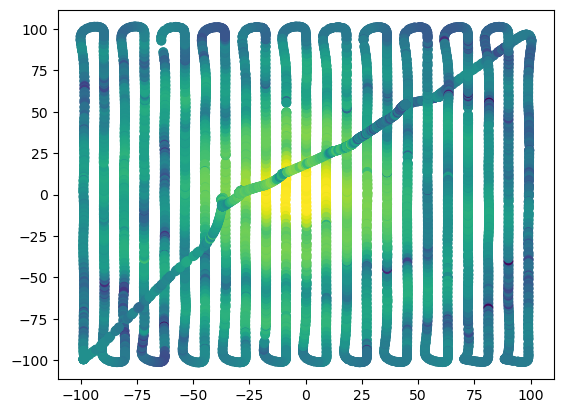

In [45]:
scatter(x,y,c = interp_data)

In [47]:
# Z_func(x_plot, y_plot).shape

In [48]:
# pcolormesh(X_plot, Y_plot, Z_func(x_plot, y_plot))

NameError: name 'X_plot' is not defined

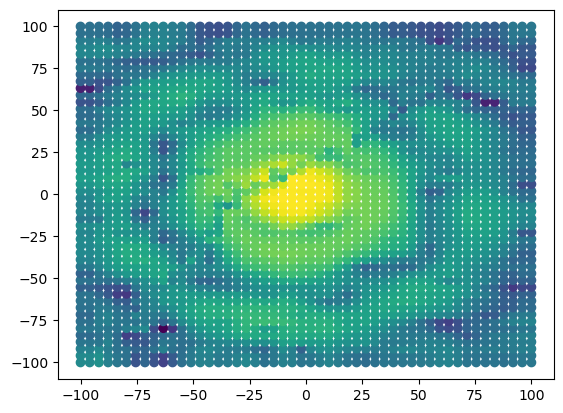

In [49]:
x_plot = np.linspace(-100,100,50)
y_plot = np.linspace(-100,100,50)

X_plot, Y_plot = np.meshgrid(x_plot, y_plot)

scatter(X_plot.ravel(),Y_plot.ravel(),c = (Z_func(x_plot, y_plot)).ravel())

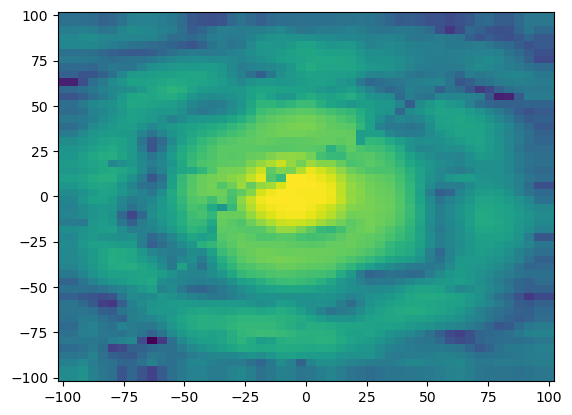

In [50]:
pcolormesh(X_plot, Y_plot, Z_func(x_plot, y_plot))

In [51]:
import math


In [52]:
def R(m,n,ρ): 
    def Rmn(k):
        numerator = (-1)**k*math.factorial(n-k)
        denominator = math.factorial(k)*math.factorial((n+m)/2-k)*math.factorial((n-m)/2-k)
        return (numerator*ρ**(n-2*k))/denominator
    
    if (n-m)%2 == 0:
        return np.sum([Rmn(k) for k in range(1+int((n-m)/2))], axis = 0)
    else:
        return np.zeros(len(ρ))

def zernike(m,n,ρ,ϕ):
    if m>=0:
        Z = R(m,n,ρ)*np.cos(m*ϕ)
    else:
        Z = R(-1*m,n,ρ)*np.sin(-1*m*ϕ)
    return Z

/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


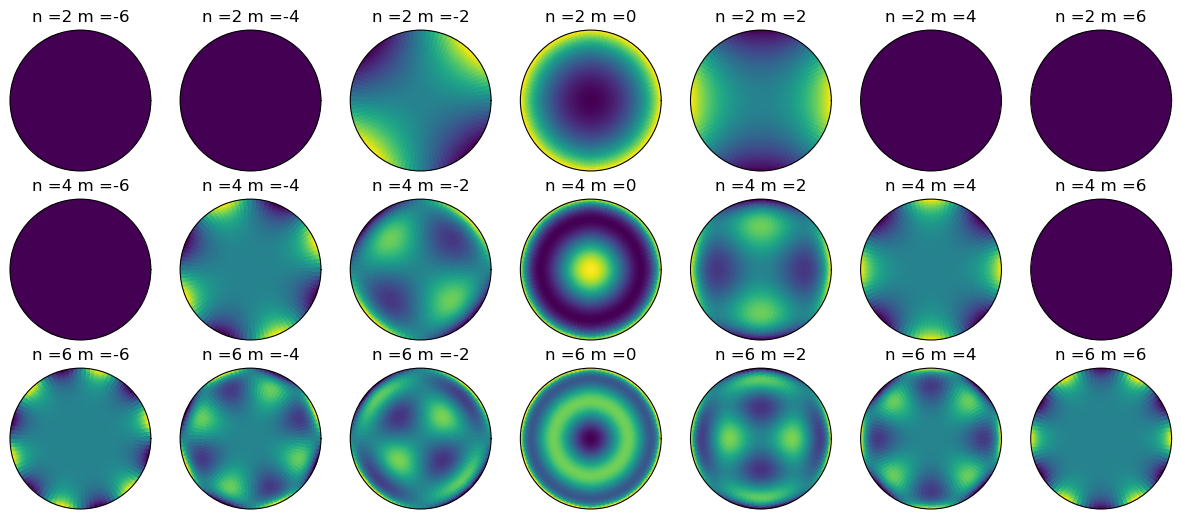

In [53]:
# demo zernike plots

z = np.zeros((100,100))
ps = np.linspace(0,0.99,100)
phis = np.linspace(0,2*np.pi,100)
fig = figure(figsize = (15,15))
counter = 1
        
for n in np.arange(2,7,2):
    for m in np.arange(-6,7,2):
        ax = fig.add_subplot(7,7,counter, projection = 'polar')
        try:
            for i in range(100):
                z[i] = zernike(m,n,ps[i], phis)
            # z[i] = zernike(m,n,ps, phis[i])
            ax.pcolormesh(phis, ps, 10**(z/10))
            ax.set_yticklabels([])
            ax.set_xticklabels([])
        except:
            pass
        
        ax.set_title('n ='+str(n)+' m ='+str(m))
        counter +=1
show()

# Fitting data

In [11]:
data = Z1

NameError: name 'Z1' is not defined

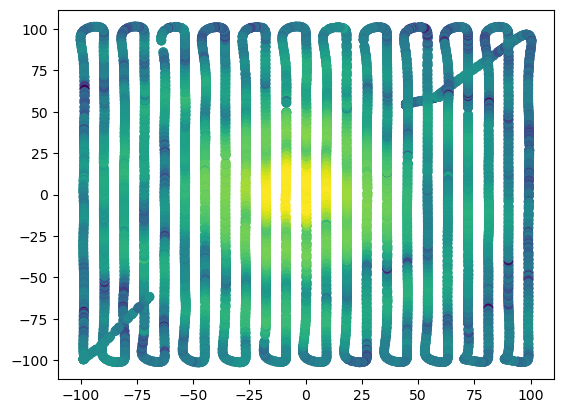

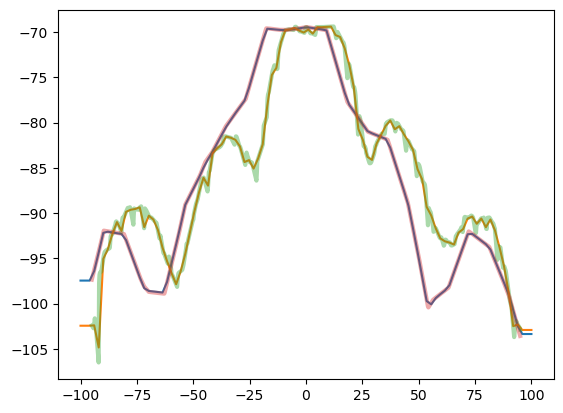

In [14]:
# Construct interpolation of data
# output: some function interp(x,y) that gives a good approximation to our beam at any x or y value

#raw position data from drone and telescope
freq = 900
num = 1

lb = 1500
ub = -1500
# lb = 0
# ub = -1

inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict826[keys826[num]].drone_xyz_LC_interp[j,0]) != 'nan']
x = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0][lb:ub]
y = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1][lb:ub]
z = (np.abs(np.mean(dict826[keys826[num]].V_bgsub[indsuse,freq:freq+20,1][lb:ub], axis = 1)))

scatter(x,y,c=10*np.log10(z))
show()
#removing nans (idk why they arise..)
indsuse = np.where((x==x)&(y==y)&(z==z))[0]
x = x[indsuse]
y = y[indsuse]
z = 10*np.log10(z[indsuse])

#interpolating onto grid, then into function
X,Y = np.meshgrid(np.linspace(-95,95,1000), np.linspace(-95,95,1000))
Z1 = griddata((x,y), z, (X,Y))
Z_func = interp2d(np.linspace(-95,95,1000), np.linspace(-95,95,1000), Z1)

#plotting as a check

xs = np.linspace(-100,100,100)
plot(xs, [Z_func(xx,0) for xx in xs])
plot(xs, [Z_func(0,xx) for xx in xs])
plot(np.linspace(-95,95,1000), Z1[:,500], linewidth = 3, alpha = 0.4)
plot(np.linspace(-95,95,1000), Z1[500,:], linewidth = 3, alpha = 0.4)


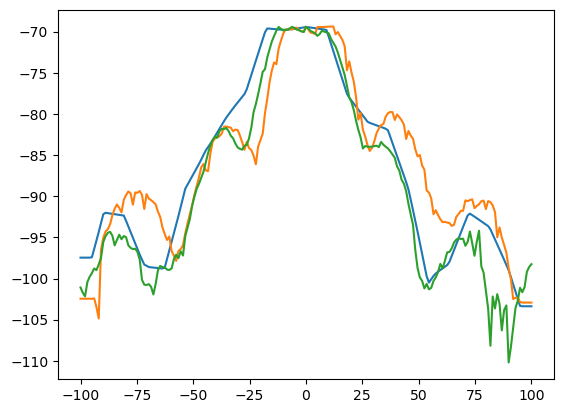

In [15]:
# Convert the interpolation to polar coordinates
# output: some function interp(r, phi) that gives a good approximation to our beam at any r or phi value

# radial function
def Z_func_r(r, theta):
    x1 = r*np.cos(theta)
    y1 = r*np.sin(theta)
    return Z_func(x1, y1)

# plotting as a check
xs = np.linspace(0,100,100)
plot(xs, [Z_func_r(xx,0) for xx in xs], color = 'C0')
plot(-1*xs, [Z_func_r(xx,np.pi) for xx in xs], color = 'C0')

plot(xs, [Z_func_r(xx,np.pi/2) for xx in xs], color = 'C1')
plot(-1*xs, [Z_func_r(xx,3*np.pi/2) for xx in xs], color = 'C1')

plot(xs, [Z_func_r(xx,np.pi/4) for xx in xs], color = 'C2')
plot(-1*xs, [Z_func_r(xx,np.pi/4+np.pi) for xx in xs], color = 'C2')


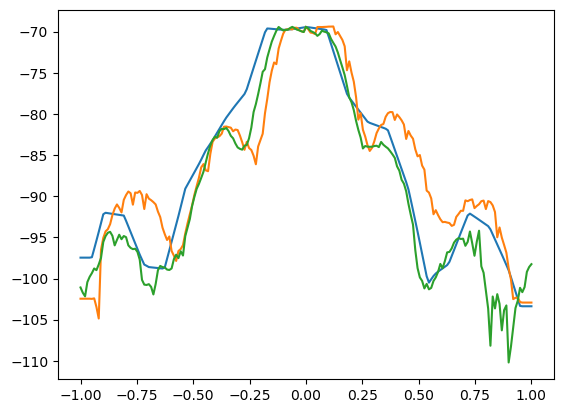

In [16]:
# Convert the interpolation to polar coordinates
# output: some function interp(r, phi) that gives a good approximation to our beam at any r or phi value

#BUT PUT ON UNIT DISK

# radial function
def Z_func_r(r, theta):
    x1 = r*np.cos(theta)*100
    y1 = r*np.sin(theta)*100
    return Z_func(x1, y1)

# plotting as a check
xs = np.linspace(0,1,100)
plot(xs, [Z_func_r(xx,0) for xx in xs], color = 'C0')
plot(-1*xs, [Z_func_r(xx,np.pi) for xx in xs], color = 'C0')

plot(xs, [Z_func_r(xx,np.pi/2) for xx in xs], color = 'C1')
plot(-1*xs, [Z_func_r(xx,3*np.pi/2) for xx in xs], color = 'C1')

plot(xs, [Z_func_r(xx,np.pi/4) for xx in xs], color = 'C2')
plot(-1*xs, [Z_func_r(xx,np.pi/4+np.pi) for xx in xs], color = 'C2')


/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


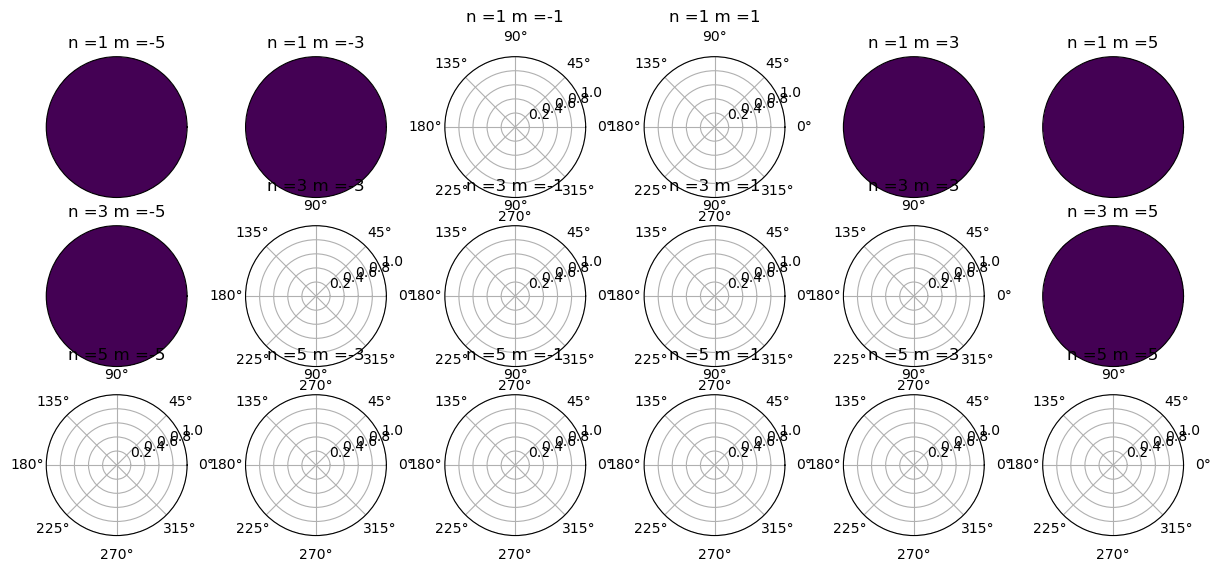

/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


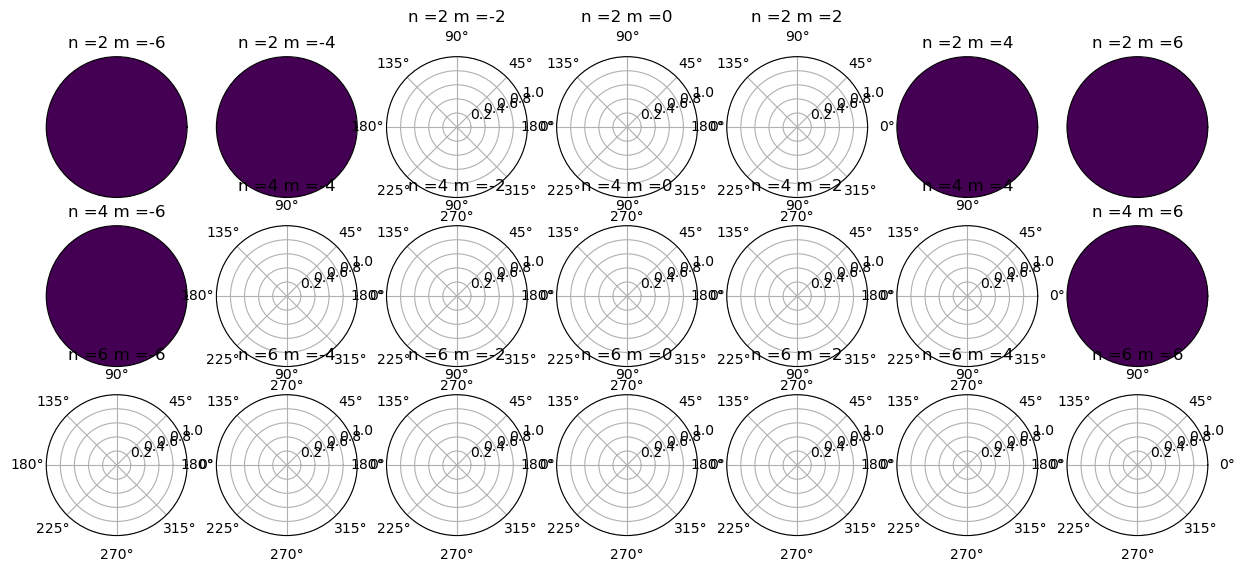

In [17]:
# Construct Zernike polynomials
# output some functions Z(n,m,rho,phi) that gives the value of the polynomial

def R(m,n,ρ): 
    def Rmn(k):
        numerator = (-1)**k*math.factorial(n-k)
        denominator = math.factorial(k)*math.factorial((n+m)/2-k)*math.factorial((n-m)/2-k)
        return (numerator*ρ**(n-2*k))/denominator
    
    if (n-m)%2 == 0:
        return np.sum([Rmn(k) for k in range(1+int((n-m)/2))], axis = 0)
    else:
        return np.zeros(len(ρ))

def zernike(m,n,ρ,ϕ):
    if m>=0:
        Z = R(m,n,ρ)*np.cos(m*ϕ)
    else:
        Z = R(-1*m,n,ρ)*np.sin(-1*m*ϕ)
    return Z

# demo zernike plots

z = np.zeros((100,100))
ps = np.linspace(0,0.99,100)
phis = np.linspace(0,2*np.pi,100)

fig = figure(figsize = (15,15))
counter = 1
for n in np.arange(1,7,2):
    for m in np.arange(-5,7,2):
        ax = fig.add_subplot(7,6,counter, projection = 'polar')
        try:
            for i in range(100):
                z[i] = zernike(m,n,ps[i], phis)
            # z[i] = zernike(m,n,ps, phis[i])
            ax.pcolormesh(phis, ps, 10**(z/10))
            ax.set_yticklabels([])
            ax.set_xticklabels([])
        except:
            pass
        
        ax.set_title('n ='+str(n)+' m ='+str(m))
        counter +=1
show()

fig = figure(figsize = (15,15))
counter = 1  
for n in np.arange(2,7,2):
    for m in np.arange(-6,7,2):
        ax = fig.add_subplot(7,7,counter, projection = 'polar')
        try:
            for i in range(100):
                z[i] = zernike(m,n,ps[i], phis)
            # z[i] = zernike(m,n,ps, phis[i])
            ax.pcolormesh(phis, ps, 10**(z/10))
            ax.set_yticklabels([])
            ax.set_xticklabels([])
        except:
            pass
        
        ax.set_title('n ='+str(n)+' m ='+str(m))
        counter +=1
show()


In [28]:
# Write function to calculate inner products (to get coefficients)
# output some function inner_product(G, Z) that returns the inner product of these two functions
import scipy
from scipy.integrate import dblquad

def zernike2(ρ,ϕ,m,n):
    if m>=0:
        Z = R(m,n,ρ)*np.cos(m*ϕ)
    else:
        Z = R(-1*m,n,ρ)*np.sin(-1*m*ϕ)
    return Z

# for n in np.arange(1,7,2):
#     for m in np.arange(-5,7,2):
#         func = lambda rho, phi: zernike2(rho, phi, m, n)*zernike2(rho, phi, m, n)*rho
#         print("n = " + str(n), "m = " + str(m), scipy.integrate.dblquad(func, 0, 2*np.pi, 0, 1)[0])
# print('')

def zernike_coefficienttest(m,n):
    if m == 0: em = 2
    else: em = 1
    
    func = lambda rho, phi: zernike2(rho, phi, m, n)*zernike2(rho, phi, m, n)*rho
    innerproduct = scipy.integrate.dblquad(func, 0, 2*np.pi, 0, 1)[0]
    coeff = innerproduct*(2*n+2)/(em*np.pi)
    return(coeff)

def zernike_coefficient(m,n):
    if m == 0: em = 2
    else: em = 1
    
    func = lambda rho, phi: zernike2(rho, phi, m, n)*Z_func_r(rho, phi)*rho
    innerproduct = scipy.integrate.dblquad(func, 0, 2*np.pi, 0, 1)[0]
    coeff = innerproduct*(2*n+2)/(em*np.pi)
    return(coeff)

print('taking inner products of zernike polynomials with themselves,\
showing that we have proper normalization')
for n in np.arange(1,7,2):
    for m in np.arange(-5,5,2):
        func = lambda rho, phi: zernike2(rho, phi, m, n)*zernike2(rho, phi, m, n)*rho
        print("n = " + str(n), "m = " + str(m), zernike_coefficienttest(m,n))

  

taking inner products of zernike polynomials with themselves,showing that we have proper normalization
n = 1 m = -5 0.0
n = 1 m = -3 0.0
n = 1 m = -1 1.0
n = 1 m = 1 1.0
n = 1 m = 3 0.0
n = 3 m = -5 0.0
n = 3 m = -3 1.0
n = 3 m = -1 1.0
n = 3 m = 1 1.0
n = 3 m = 3 1.0000000000000002
n = 5 m = -5 1.0000000000000007
n = 5 m = -3 1.0000000000000002
n = 5 m = -1 1.0000000000000009
n = 5 m = 1 1.0000000000000002
n = 5 m = 3 1.0000000000000002


In [59]:
# Calculate all coefficients and build Zernike expansion
# output some analytical approximation to our data

#find m, n where zernike polynomials exist.. if that is even right thing to say
usable_mn = []
for n in np.arange(1,7,1):
    for m in np.arange(-7,7,1):
        try:
            if zernike_coefficienttest(m,n) != 0:
                usable_mn.append((m, n))
        except: pass

Now just check that we can expand an existing zernike polynomial in basis..

In [63]:
def zernike_coefficienttest_11(m,n):
    if m == 0: em = 2
    else: em = 1
    
    func = lambda rho, phi: zernike2(rho, phi, m, n)*zernike2(rho, phi, 1, 1)*rho
    innerproduct = scipy.integrate.dblquad(func, 0, 2*np.pi, 0, 1)[0]
    coeff = innerproduct*(2*n+2)/(em*np.pi)
    return(coeff)

coeffs = {}
for m, n in usable_mn: 
    coeffs[n] = {}

for m, n in usable_mn: 
    coeffs[n][m] = round(zernike_coefficienttest_11(m,n))

In [64]:
for m, n in usable_mn: 
    print(n, m, '  ', coeffs[n][m])

1 -1    0
1 1    1
2 -2    0
2 0    0
2 2    0
3 -3    0
3 -1    0
3 1    0
3 3    0
4 -4    0
4 -2    0
4 0    0
4 2    0
4 4    0
5 -5    0
5 -3    0
5 -1    0
5 1    0
5 3    0
5 5    0
6 -6    0
6 -4    0
6 -2    0
6 0    0
6 2    0
6 4    0
6 6    0


In [659]:
# counter = 0
# for m, n in usable_mn: 
#     print("\r  --> Loading m,n: {}/{}".format(counter,27),end="")
    
#     coeffs[n][m] = zernike_coefficient(m,n)
#     counter +=1

  --> Loading m,n: 26/27

In [660]:
coeffs

{1: {-1: -0.9042786398129952, 1: -1.9020944833994187},
 2: {-2: -0.9970247990430178, 0: -9.801007896987526, 2: -0.2045789717030795},
 3: {-3: 0.6069626741318399,
  -1: -0.8608039074746728,
  1: -0.25690401168686855,
  3: 0.3395870147309892},
 4: {-4: -1.6015255189188307,
  -2: 0.4072408608572223,
  0: 5.188024238345168,
  2: 2.330951588031296,
  4: 1.237740503979065},
 5: {-5: -0.25096763870783023,
  -3: -0.43171374810194385,
  -1: 1.8557885880076372,
  1: -2.153156883259295,
  3: -1.8729524277143252,
  5: 0.3403188542588794},
 6: {-6: 1.096064899062875,
  -4: 0.21695459257029878,
  -2: -0.29893962751791264,
  0: -7.356952465952778,
  2: 0.18022556256585937,
  4: -1.255050126711541,
  6: -0.31784567963176513}}

/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


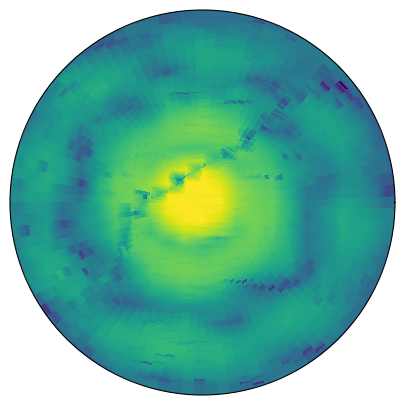

In [661]:
#make sure I can plot data this way...

z = np.zeros((100,100))
ps = np.linspace(0,0.99,100)
phis = np.linspace(0,2*np.pi,100)

beam = np.zeros((100,100))
z = np.zeros((100,100))
for i in range(100):
    for j in range(100):
#         z[i] = zernike(m,n,ps[i], phis)
        z[i][j] = Z_func_r(ps[i], phis[j])
#     print(coeffs[n][m])
beam = beam + z

fig = figure(figsize = (5,5))
ax = fig.add_subplot(111, projection = 'polar')
ax.pcolormesh(phis, ps, beam)
ax.set_yticklabels([])
ax.set_xticklabels([])
# ax.set_title('n ='+str(n)+' m ='+str(m))
counter +=1
show()


/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  
/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


[Text(0.0, 0, ''),
 Text(0.7853981633974483, 0, ''),
 Text(1.5707963267948966, 0, ''),
 Text(2.356194490192345, 0, ''),
 Text(3.141592653589793, 0, ''),
 Text(3.9269908169872414, 0, ''),
 Text(4.71238898038469, 0, ''),
 Text(5.497787143782138, 0, '')]

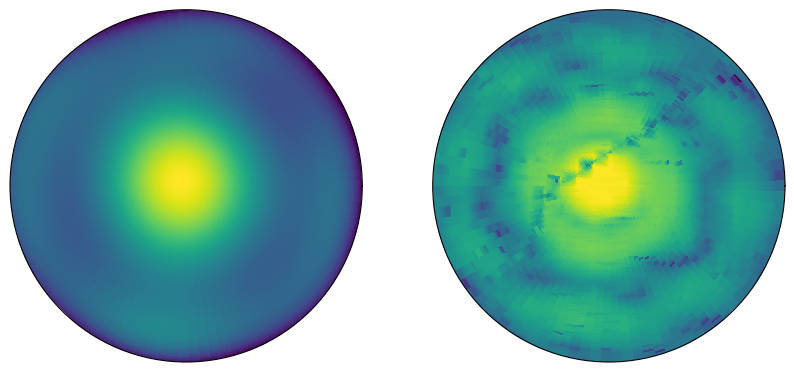

In [666]:
fig = figure(figsize = (10,5))

z = np.zeros((100,100))
ps = np.linspace(0,0.99,100)
phis = np.linspace(0,2*np.pi,100)

beam = np.zeros((100,100))
for m, n in usable_mn: 
    z = np.zeros((100,100))
    for i in range(100):
#         z[i] = zernike(m,n,ps[i], phis)
        z[i] = coeffs[n][m]*zernike(m,n,ps[i], phis)
#     print(coeffs[n][m])
    beam = beam + z
ax = fig.add_subplot(121, projection = 'polar')
ax.pcolormesh(phis, ps, beam)
ax.set_yticklabels([])
ax.set_xticklabels([])


###data

beam1 = np.zeros((100,100))
z = np.zeros((100,100))
for i in range(100):
    for j in range(100):
#         z[i] = zernike(m,n,ps[i], phis)
        z[i][j] = Z_func_r(ps[i], phis[j])
#     print(coeffs[n][m])
beam1 = beam1 + z

ax = fig.add_subplot(122, projection = 'polar')
ax.pcolormesh(phis, ps, beam1)
ax.set_yticklabels([])
ax.set_xticklabels([])

/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  """


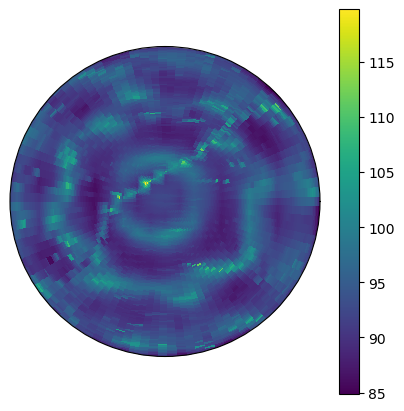

In [671]:
fig = figure(figsize = (5,5))
ax = fig.add_subplot(111, projection = 'polar')
ax.set_yticklabels([])
ax.set_xticklabels([])
im = ax.pcolormesh(phis, ps, beam-beam1)

fig.colorbar(im, orientation='vertical')


/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  
/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


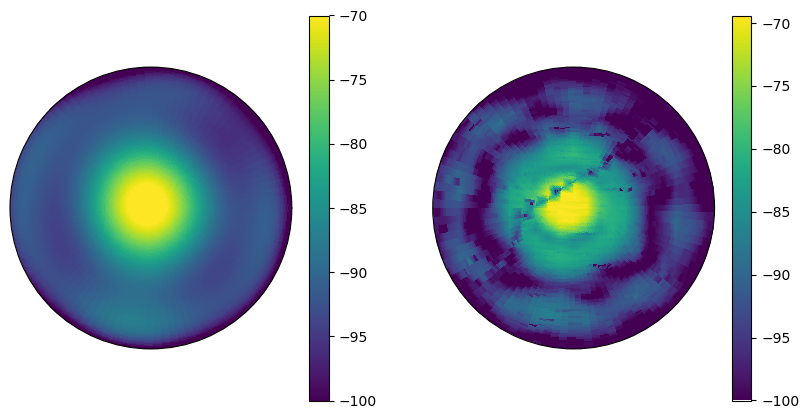

In [786]:
fig = figure(figsize = (10,5))

z = np.zeros((100,100))
ps = np.linspace(0,0.99,100)
phis = np.linspace(0,2*np.pi,100)

beam = np.zeros((100,100))
for m, n in usable_mn: 
    z = np.zeros((100,100))
    for i in range(100):
#         z[i] = zernike(m,n,ps[i], phis)
        z[i] = coeffs[n][m]*zernike(m,n,ps[i], phis)
#     print(coeffs[n][m])
    beam = beam + z
ax = fig.add_subplot(121, projection = 'polar')
im = ax.pcolormesh(phis, ps, beam-90, vmin = -100, vmax = -70)
ax.set_yticklabels([])
ax.set_xticklabels([])
fig.colorbar(im, orientation='vertical')


###data

beam1 = np.zeros((100,100))
z = np.zeros((100,100))
for i in range(100):
    for j in range(100):
#         z[i] = zernike(m,n,ps[i], phis)
        z[i][j] = Z_func_r(ps[i], phis[j])
#     print(coeffs[n][m])
beam1 = beam1 + z

ax = fig.add_subplot(122, projection = 'polar')
im = ax.pcolormesh(phis, ps, beam1, vmin = -100)
ax.set_yticklabels([])
ax.set_xticklabels([])
fig.colorbar(im, orientation='vertical')


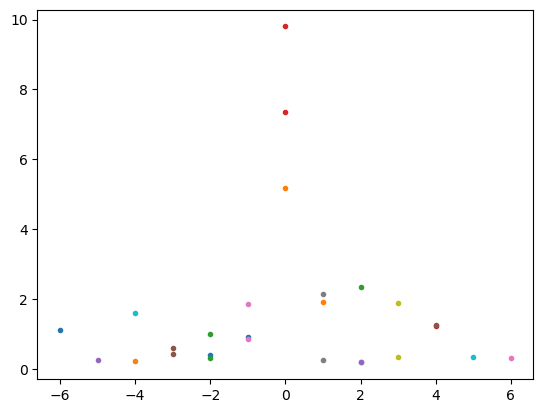

In [689]:
for m, n in usable_mn: 
    plot(m, np.abs(coeffs[n][m]), '.')

# try with looser error...

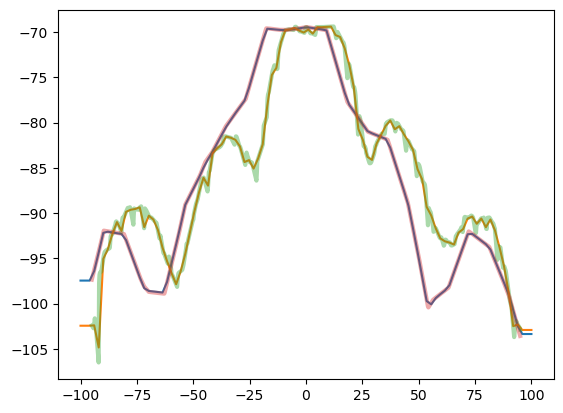

In [166]:
# Construct interpolation of data
# output: some function interp(x,y) that gives a good approximation to our beam at any x or y value

#raw position data from drone and telescope
freq = 900
num = 1
inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict826[keys826[num]].drone_xyz_LC_interp[j,0]) != 'nan']
x = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0]
y = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1]
z = (np.abs(np.mean(dict826[keys826[num]].V_bgsub[indsuse,freq:freq+20,1], axis = 1)))



lb = 1500
ub = -1500
# lb = 0
# ub = -1

inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict826[keys826[num]].drone_xyz_LC_interp[j,0]) != 'nan']
x = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0][lb:ub]
y = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1][lb:ub]
z = (np.abs(np.mean(dict826[keys826[num]].V_bgsub[indsuse,freq:freq+20,1][lb:ub], axis = 1)))



#removing nans (idk why they arise..)
indsuse = np.where((x==x)&(y==y)&(z==z))[0]
x = x[indsuse]
y = y[indsuse]
z = 10*np.log10(z[indsuse])

#interpolating onto grid, then into function
X,Y = np.meshgrid(np.linspace(-95,95,1000), np.linspace(-95,95,1000))
Z1 = griddata((x,y), z, (X,Y))
Z_func = interp2d(np.linspace(-95,95,1000), np.linspace(-95,95,1000), Z1)

#plotting as a check

xs = np.linspace(-100,100,100)
plot(xs, [Z_func(xx,0) for xx in xs])
plot(xs, [Z_func(0,xx) for xx in xs])
plot(np.linspace(-95,95,1000), Z1[:,500], linewidth = 3, alpha = 0.4)
plot(np.linspace(-95,95,1000), Z1[500,:], linewidth = 3, alpha = 0.4)


In [168]:
#find m, n where zernike polynomials exist.. if that is even right thing to say
usable_mn = []
for n in np.arange(1,7,1):
    for m in np.arange(-7,7,1):
        try:
            if zernike_coefficienttest(m,n) != 0:
                usable_mn.append((m, n))
        except: pass

In [169]:
len(usable_mn)

27

In [784]:
def zernike_coefficient(m,n, error=1.49e-3):
    if m == 0: em = 2
    else: em = 1
    
    func = lambda rho, phi: zernike2(rho, phi, m, n)*Z_func_r(rho, phi)*rho
    innerproduct = scipy.integrate.dblquad(func, 0, 2*np.pi, 0, 1, epsabs=error, epsrel=error)[0]
    coeff = innerproduct*(2*n+2)/(em*np.pi)
    return(coeff)

In [785]:
counter = 0
for m, n in usable_mn: 
    print("\r  --> Loading m,n: {}/{}".format(counter,27),end="")
    
    coeffs[n][m] = zernike_coefficient(m,n)
    counter +=1

  --> Loading m,n: 3/27

/home/erk26/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  **opt)


  --> Loading m,n: 26/27

In [729]:
# # coeffs_norm = {}
# # for m, n in usable_mn: 
# #     coeffs_norm[n] = {}

# counter = 0
# for m, n in usable_mn[13:]: 
#     print("\r  --> Loading m,n: {}/{}".format(counter,27),end="")
    
#     coeffs_norm[n][m] = zernike_coefficient(m,n)
#     counter +=1

In [ ]:
coeffs_norm

1.0000000000000002

In [744]:
def zernike_coefficient_connor(m,n, error=1e-2):
    if m == 0: em = 2
    else: em = 1
    
    func = lambda rho, phi: Z_func_r(rho, phi)
    innerproduct = scipy.integrate.dblquad(func, 0, 2*np.pi, 0, 1, epsabs=error, epsrel=error)[0]
#     coeff = innerproduct*(2*n+2)/(em*np.pi)
    return(innerproduct)

In [767]:
func_connor = lambda rho, phi: zernike2(rho, phi, 1, 1)*Z_func_r(rho, phi)*rho
# func_connor = lambda rho, phi: Z_func_r(rho, phi)*rho
ans = scipy.integrate.dblquad(func_connor, 0, 2*np.pi, 0, 1, epsabs=1e-2, epsrel=1e-2)

In [788]:
[zernike2(r, 0, 1,1) for r in np.linspace(0,1,10000)];

In [783]:
[Z_func_r(r, 0)*zernike2(r, 0, 1,1) for r in np.linspace(0,1,10000)];

/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10
/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


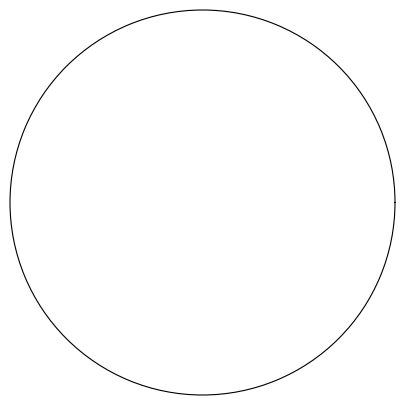

In [165]:
#make sure I can plot data this way...

z = np.zeros((100,100))
ps = np.linspace(0,0.99,100)
phis = np.linspace(0,2*np.pi,100)

beam = np.zeros((100,100))
z = np.zeros((100,100))
for i in range(100):
    for j in range(100):
#         z[i] = zernike(m,n,ps[i], phis)
        z[i][j] = Z_func_r(ps[i], phis[j])
#     print(coeffs[n][m])
beam = beam + z

fig = figure(figsize = (5,5))
ax = fig.add_subplot(111, projection = 'polar')
ax.pcolormesh(phis, ps, np.log10(beam))
ax.set_yticklabels([])
ax.set_xticklabels([])
# ax.set_title('n ='+str(n)+' m ='+str(m))
counter +=1
show()


In [790]:
Z1.shape

(1000, 1000)

In [825]:
func_connor = lambda rho, phi: Z_func_r(rho, phi)*rho
# func_connor = lambda rho, phi: Z_func_r(rho, phi)*rho
scipy.integrate.dblquad(func_connor, 0, 2*np.pi, 0, 1, epsabs=1e-2, epsrel=1e-2)

(-292.4461832969006, 2.819034860352934)

In [796]:
Z1[500,500]

-69.4431324127622

In [797]:
Z_func_r(0,0)

array([-69.44880632])

In [807]:
functest = np.abs(X) + np.abs(Y)

In [828]:
func_connor

<function __main__.<lambda>(rho, phi)>

In [810]:
# func_connor = lambda rho, phi: np.abs(rho)+np.abs(phi)
# # func_connor = lambda rho, phi: Z_func_r(rho, phi)*rho
# scipy.integrate.dblquad(func_connor, -95, 95, -95, 95, epsabs=1e-2, epsrel=1e-2)

(3429500.0, 3.8067810237407684e-08)

In [851]:
vol = 0
dr = 0.01
dθ = 0.01
for θ in np.arange(0, 2*np.pi, dθ):
    for r in np.arange(0,1,dr):
        vol += dr*dθ*r*Z_func_r(r, θ)*zernike2(r, θ, 1, 1)
                       

In [852]:
vol

array([-1.68056972])

In [842]:
func = lambda rho, phi: zernike2(rho, phi, 1, 1)*Z_func_r(rho, phi)*rho
innerproduct = scipy.integrate.dblquad(func, 0, 2*np.pi, 0, 1, epsabs=1e-2, epsrel=1e-2)[0]

/home/erk26/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)


In [845]:
innerproduct

-1.4915590652865272

# now trying with reimman sum..

In [18]:
def zernike_coefficient_reimann(m,n):
    if m == 0: em = 2
    else: em = 1
        
    innerproduct = 0
    dr = 0.01
    dθ = 0.01
    for θ in np.arange(0, 2*np.pi, dθ):
        for r in np.arange(0,1,dr):
            innerproduct += dr*dθ*r*Z_func_r(r, θ)*zernike2(r, θ, m, n)

    coeff = innerproduct*(2*n+2)/(em*np.pi)
    return(coeff)

In [19]:
4%2

0

In [20]:
usable_mn = []
for n in np.arange(1,30,1):
    for m in np.arange(-30,30,1):
        if np.abs(m)<=n:
            if n%2==m%2: 
                usable_mn.append((m, n))

#         try:
#             if zernike_coefficienttest(m,n) != 0:
#         usable_mn.append((m, n))
#         except: pass

In [21]:
len(usable_mn)

464

In [22]:
coeffs_reimann2 = {}
for m, n in usable_mn: 
    coeffs_reimann2[n] = {}

In [29]:
counter = 0
for m, n in usable_mn: 
    print("\r  --> Loading m,n: {}/{}".format(counter,len(usable_mn)),end="")
    
    coeffs_reimann2[n][m] = zernike_coefficient_reimann(m,n)
    counter +=1

  --> Loading m,n: 463/464

/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


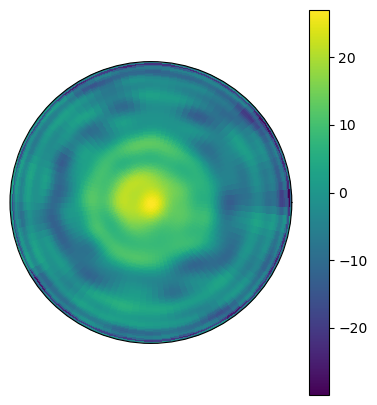

In [30]:
fig = figure(figsize = (10,5))

z = np.zeros((100,100))
ps = np.linspace(0,0.99,100)
phis = np.linspace(0,2*np.pi,100)

beam_reimann = np.zeros((100,100))
for m, n in usable_mn: 
    z = np.zeros((100,100))
    for i in range(100):
#         z[i] = zernike(m,n,ps[i], phis)
        z[i] = coeffs_reimann2[n][m]*zernike(m,n,ps[i], phis)
#     print(coeffs[n][m])
    beam_reimann = beam_reimann + z
ax = fig.add_subplot(121, projection = 'polar')
im = ax.pcolormesh(phis, ps, beam_reimann)
ax.set_yticklabels([])
ax.set_xticklabels([])
fig.colorbar(im, orientation='vertical')



/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  """
/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


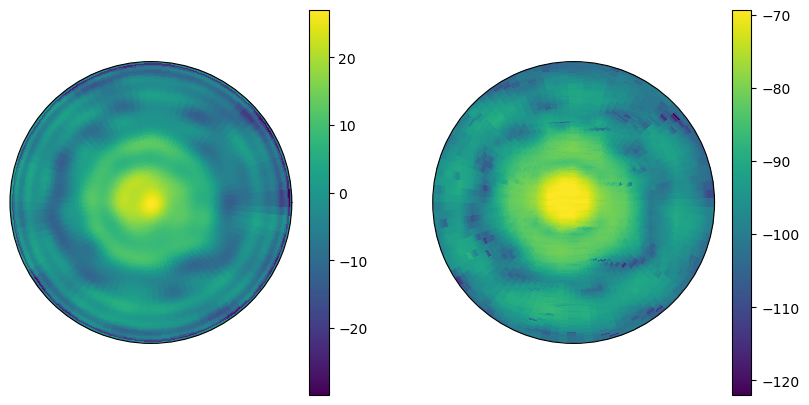

In [31]:
fig = figure(figsize = (10,5))


ax = fig.add_subplot(121, projection = 'polar')
im = ax.pcolormesh(phis, ps, beam_reimann)
ax.set_yticklabels([])
ax.set_xticklabels([])
fig.colorbar(im, orientation='vertical')


###data

beam1 = np.zeros((100,100))
z = np.zeros((100,100))
for i in range(100):
    for j in range(100):
#         z[i] = zernike(m,n,ps[i], phis)
        z[i][j] = Z_func_r(ps[i], phis[j])
#     print(coeffs[n][m])
beam1 = beam1 + z

ax = fig.add_subplot(122, projection = 'polar')
im = ax.pcolormesh(phis, ps, beam1)
ax.set_yticklabels([])
ax.set_xticklabels([])
fig.colorbar(im, orientation='vertical')


/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  after removing the cwd from sys.path.


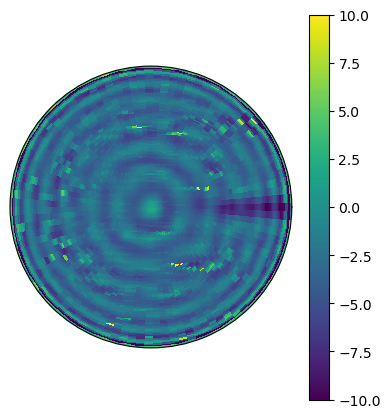

In [32]:
fig = figure(figsize = (10,5))

ax = fig.add_subplot(121, projection = 'polar')
im = ax.pcolormesh(phis, ps, beam_reimann-beam1-95, vmin = -10, vmax = 10)
ax.set_yticklabels([])
ax.set_xticklabels([])
fig.colorbar(im, orientation='vertical')



NameError: name 'beam' is not defined

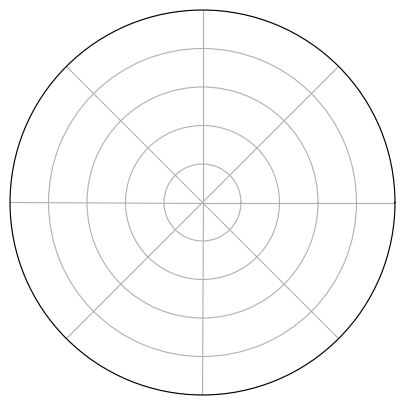

In [34]:
fig = figure(figsize = (5,5))
ax = fig.add_subplot(111, projection = 'polar')
ax.set_yticklabels([])
ax.set_xticklabels([])
im = ax.pcolormesh(phis, ps, (beam))

fig.colorbar(im, orientation='vertical')

In [ ]:
most_weighted_coeff = []  
for m, n in usable_mn:
    if m == 0:
        plot(n, coeffs_reimann2[n][m], 'k.')
    else:
        plot(n, coeffs_reimann2[n][m], '.')
        
    if np.abs(coeffs_reimann2[n][m])>1: most_weighted_coeff.append((m,n))

In [ ]:
# most_weighted_coeff

In [ ]:
coeffs_reimann_mostweighted = {}
for m, n in most_weighted_coeff: 
    coeffs_reimann_mostweighted[n] = {}
    
counter = 0
for m, n in most_weighted_coeff:     
    coeffs_reimann_mostweighted[n][m] = coeffs_reimann2[n][m]


/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  """


NameError: name 'most_weighted_coeff' is not defined

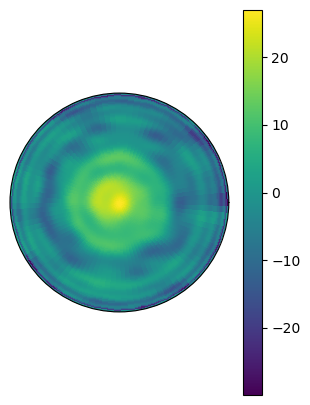

In [35]:
fig = figure(figsize = (12,5))


ax = fig.add_subplot(131, projection = 'polar')
im = ax.pcolormesh(phis, ps, beam_reimann)
ax.set_yticklabels([])
ax.set_xticklabels([])
fig.colorbar(im, orientation='vertical')


beam_weightedcoeffs = np.zeros((100,100))
for m, n in most_weighted_coeff: 
    z = np.zeros((100,100))
    for i in range(100):
        z[i] = coeffs_reimann_mostweighted[n][m]*zernike(m,n,ps[i], phis)
    beam_weightedcoeffs = beam_weightedcoeffs + z
    
ax = fig.add_subplot(132, projection = 'polar')
im = ax.pcolormesh(phis, ps, beam_weightedcoeffs)
ax.set_yticklabels([])
ax.set_xticklabels([])
fig.colorbar(im, orientation='vertical')


###data

beam1 = np.zeros((100,100))
z = np.zeros((100,100))
for i in range(100):
    for j in range(100):
#         z[i] = zernike(m,n,ps[i], phis)
        z[i][j] = Z_func_r(ps[i], phis[j])
#     print(coeffs[n][m])
beam1 = beam1 + z

ax = fig.add_subplot(133, projection = 'polar')
im = ax.pcolormesh(phis, ps, beam1)
ax.set_yticklabels([])
ax.set_xticklabels([])
fig.colorbar(im, orientation='vertical')


/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  after removing the cwd from sys.path.


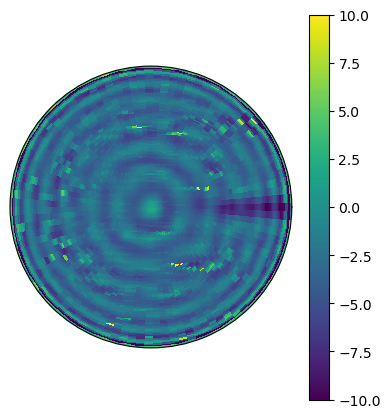

In [36]:
fig = figure(figsize = (10,5))

ax = fig.add_subplot(121, projection = 'polar')
im = ax.pcolormesh(phis, ps, beam_reimann-beam1-95, vmin = -10, vmax = 10)
ax.set_yticklabels([])
ax.set_xticklabels([])
fig.colorbar(im, orientation='vertical')



/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  after removing the cwd from sys.path.


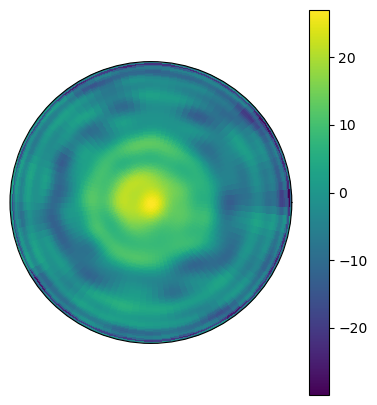

In [37]:
fig = figure(figsize = (10,5))

ax = fig.add_subplot(121, projection = 'polar')
im = ax.pcolormesh(phis, ps, beam_reimann-beam_weightedcoeffs)
ax.set_yticklabels([])
ax.set_xticklabels([])
fig.colorbar(im, orientation='vertical')



In [1]:
# apply this analysis to sims .. make new notebook, ... anyway 